In [1]:
#meta 5/1/2021 Web of Sciences Data - Data prep
#NLP, hierarchical text classification
#src data https://data.mendeley.com/datasets/9rw3vkcfy4/2
#citation: Kowsari, Kamran (2017), “Web of Science”, Mendeley Data, V2, doi: 10.17632/9rw3vkcfy4.2

#input: WOS5736 X and y files
#output: WOS5736_df.pkl with X input and y output (3 levels)

#history
#5/1/2021 READ INPUT FILES AND BUILD A LEARNING SET
#      Prep data - X, y w/11 lables
#      (plus level 1 and level 2 target vars)

#5/3/2021 LEARNING SET, STRATIFIED VALIDATION SET
#      StratifiedShuffleSplit to create a proportional validation set
#      mysrc: my-fastai-project/my-kaggle-cassava-0-data.ipynb


In [2]:
%matplotlib inline
#import time as time #to track performance time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

#stratified split
from sklearn.model_selection import StratifiedShuffleSplit
from joblib import load, dump


In [3]:
#global vars
VALID_DS_SIZE = 0.2
SEED = 24

# LSHTC: Data Prep for Classifying Text

## 0. Load Data
input: a prepared pickle with less labels (~).

In [4]:
df = load('myData/WOS5736_df.pkl') 
print(df.shape)
print(df.columns)
df.head()


(5736, 4)
Index(['X', 'y_l1', 'y_l2', 'y'], dtype='object')


,X,y_l1,y_l2,y
0,Phytoplasmas are insect-vectored bacteria that...,2,2,9
1,"Background: (-)-alpha-Bisabolol, also known as...",2,0,7
2,A universal feature of the replication of posi...,2,0,7
3,"1,2-Dichloropropane (1,2-DCP) and dichlorometh...",2,2,9
4,This paper presents the simulation results of ...,0,1,1


## 1. Data Prep
Tidy data - pick relevant columns

In [5]:
df_tidy = df[['X', 'y']].copy()
df_tidy.columns = ['text', 'label']
df_tidy['label'] = df_tidy['label'].astype('category')
df_tidy.dtypes

text       object
label    category
dtype: object

ML Expected Format: input features X(matrix) and target variable y(categorical).  
X - column 'text'  
y - columns with 'label' 

In [6]:
#preview dataset
df_tidy.head()

,text,label
0,Phytoplasmas are insect-vectored bacteria that...,9
1,"Background: (-)-alpha-Bisabolol, also known as...",7
2,A universal feature of the replication of posi...,7
3,"1,2-Dichloropropane (1,2-DCP) and dichlorometh...",9
4,This paper presents the simulation results of ...,1


In [7]:
#reset index - fast.ai dataloaders don't like a gap in index
#to avoid -> TypeError: 'float' object is not iterable
#$note: if need to preserve 'docno', set drop = False
##df_tidy.reset_index(drop=True, inplace=True)
##df_tidy.head(2)


### 1.1 Stratified Split
`StratifiedShuffleSplit` to create a proportional validation set

mysrc: my-fastai-project/my-kaggle-cassava-0-data.ipynb 


In [8]:
X = df_tidy['text']
y= df_tidy['label']

sss = StratifiedShuffleSplit(n_splits=1, test_size = VALID_DS_SIZE, random_state=SEED)
sss.get_n_splits(X,y)

1

In [9]:
for train_idx, valid_idx in sss.split(X,y):
    print('TRAIN: ', train_idx[:10], '\nVALID: ', valid_idx[:10])
    y_train, y_valid = y[train_idx], y[valid_idx]
    
y_train.value_counts().sort_index(), y_valid.value_counts().sort_index()

TRAIN:  [  44 4553 2600 1416 5430 4364 4656 4765 1453 3353] 
VALID:  [5286 2433 2878 2830  828 4869 5173 3622 2751 3982]


(0     357
 1     341
 2     335
 3     318
 4     323
 5     304
 6     333
 7     597
 8     521
 9     600
 10    559
 Name: label, dtype: int64,
 0      90
 1      85
 2      84
 3      79
 4      81
 5      76
 6      83
 7     149
 8     131
 9     150
 10    140
 Name: label, dtype: int64)

Visualize proportions

Text(0.5, 1.0, 'Target value - Validation ds')

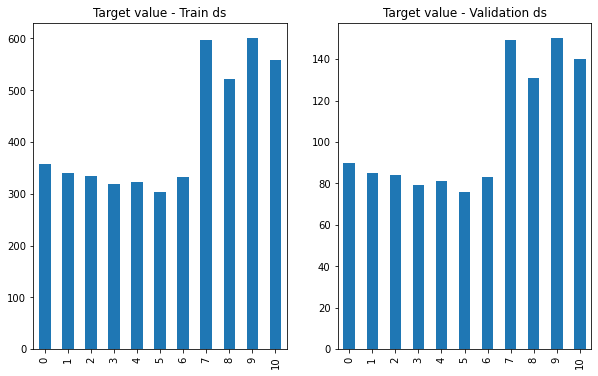

In [10]:
fig, ax = plt.subplots(1,2)
y_train.value_counts().sort_index().plot(kind='bar', ax=ax[0]);
y_valid.value_counts().sort_index().plot(kind='bar', ax=ax[1]);
ax[0].set_title('Target value - Train ds')
ax[1].set_title('Target value - Validation ds')

In [11]:
#update dataset with valid index
df_tidy['is_valid'] = 0
df_tidy.loc[df_tidy.index.isin(valid_idx), 'is_valid'] = 1
df_tidy['is_valid'].value_counts()

0    4588
1    1148
Name: is_valid, dtype: int64

In [13]:
#preview ready dataset
df_tidy.head()

,text,label,is_valid
0,Phytoplasmas are insect-vectored bacteria that...,9,0
1,"Background: (-)-alpha-Bisabolol, also known as...",7,0
2,A universal feature of the replication of posi...,7,0
3,"1,2-Dichloropropane (1,2-DCP) and dichlorometh...",9,0
4,This paper presents the simulation results of ...,1,0


Save file ready for classificaiton

In [12]:
#save file prepped for classification
dump(df_tidy, 'myOutput/WOS5736_df_tidy.pkl')

['myOutput/WOS5736_df_tidy.pkl']

##### Xtra